In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import tushare as ts
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
#set parameters
timestep = 1  
batch_size = 16  
input_dim = 7  # number of features
hidden_dim = 64  
output_dim = 1  
num_layers = 3  # LSTM layers
epochs = 10
best_loss = 0
model_name = 'gru'
save_path = './{}.pth'.format(model_name)


<Figure size 3000x800 with 0 Axes>

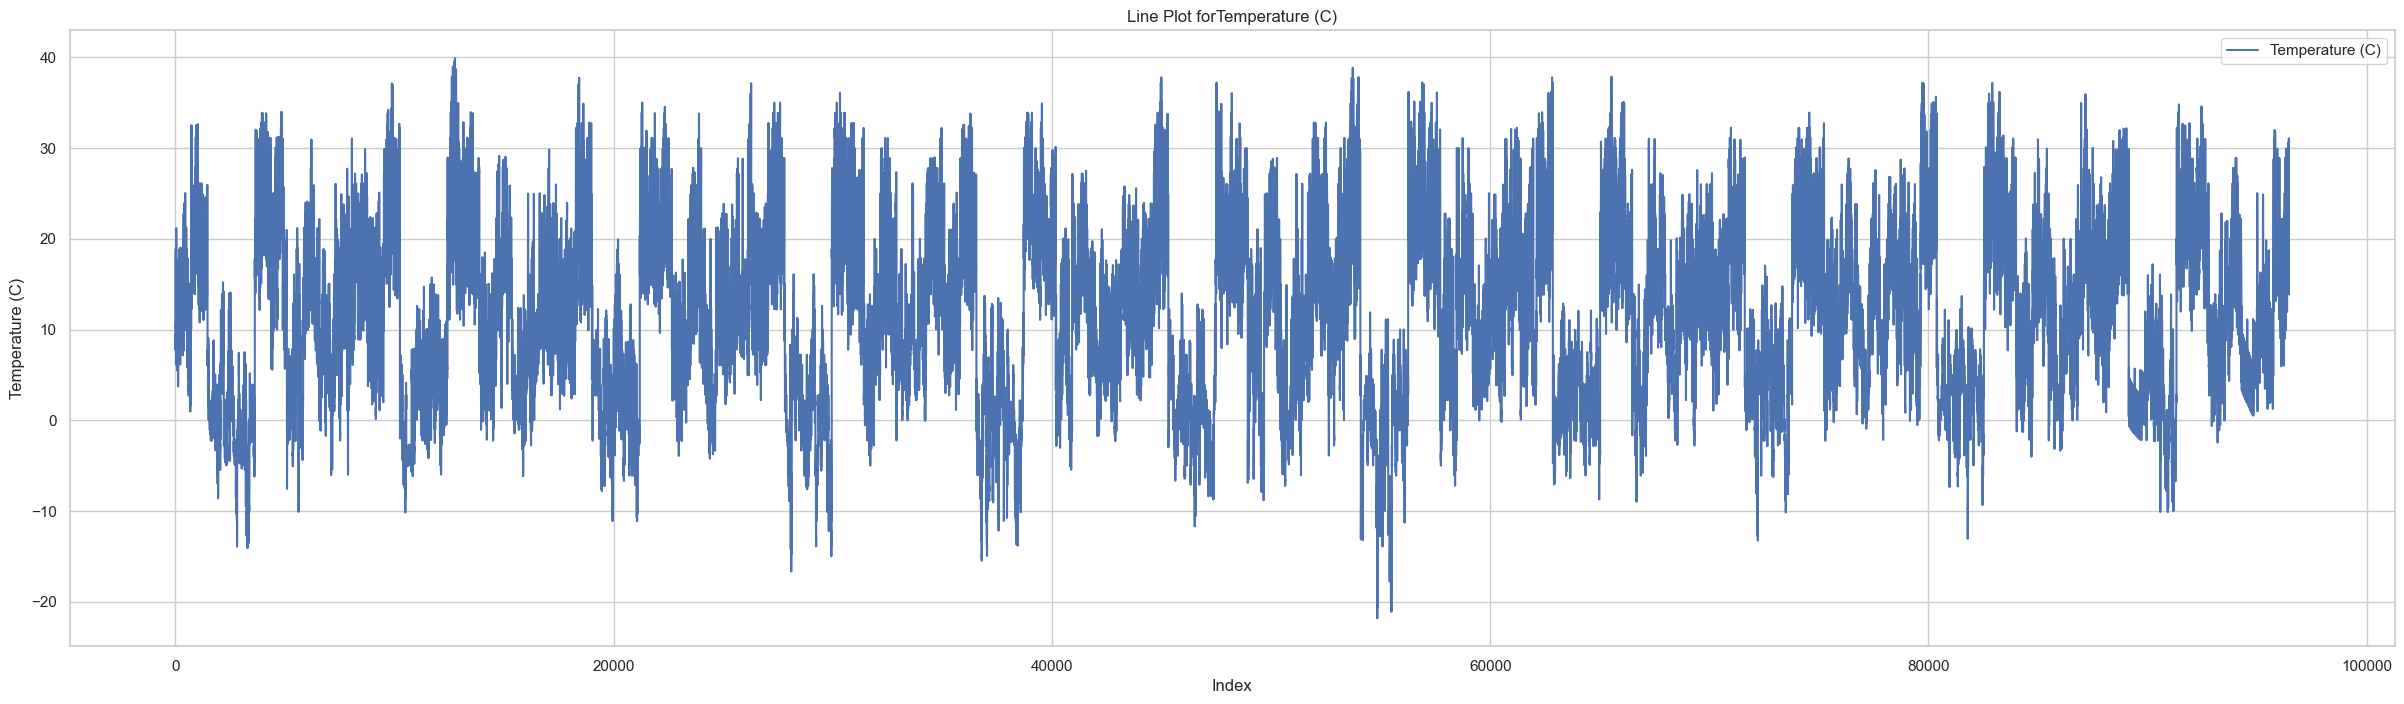

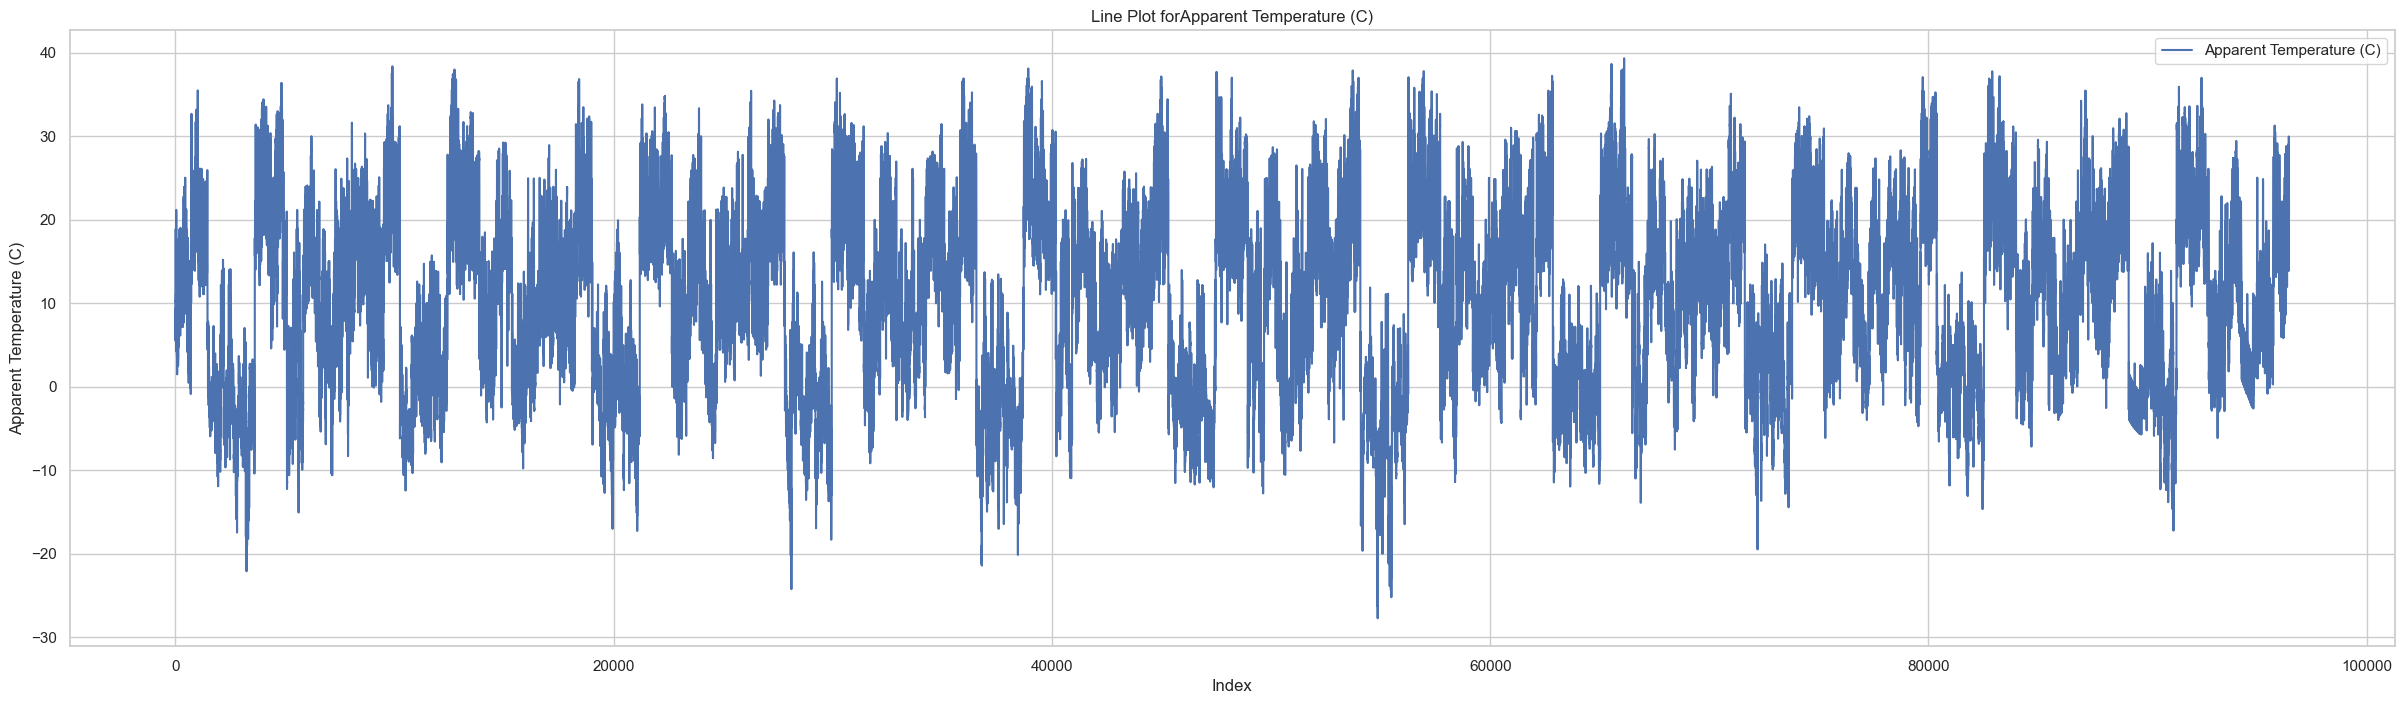

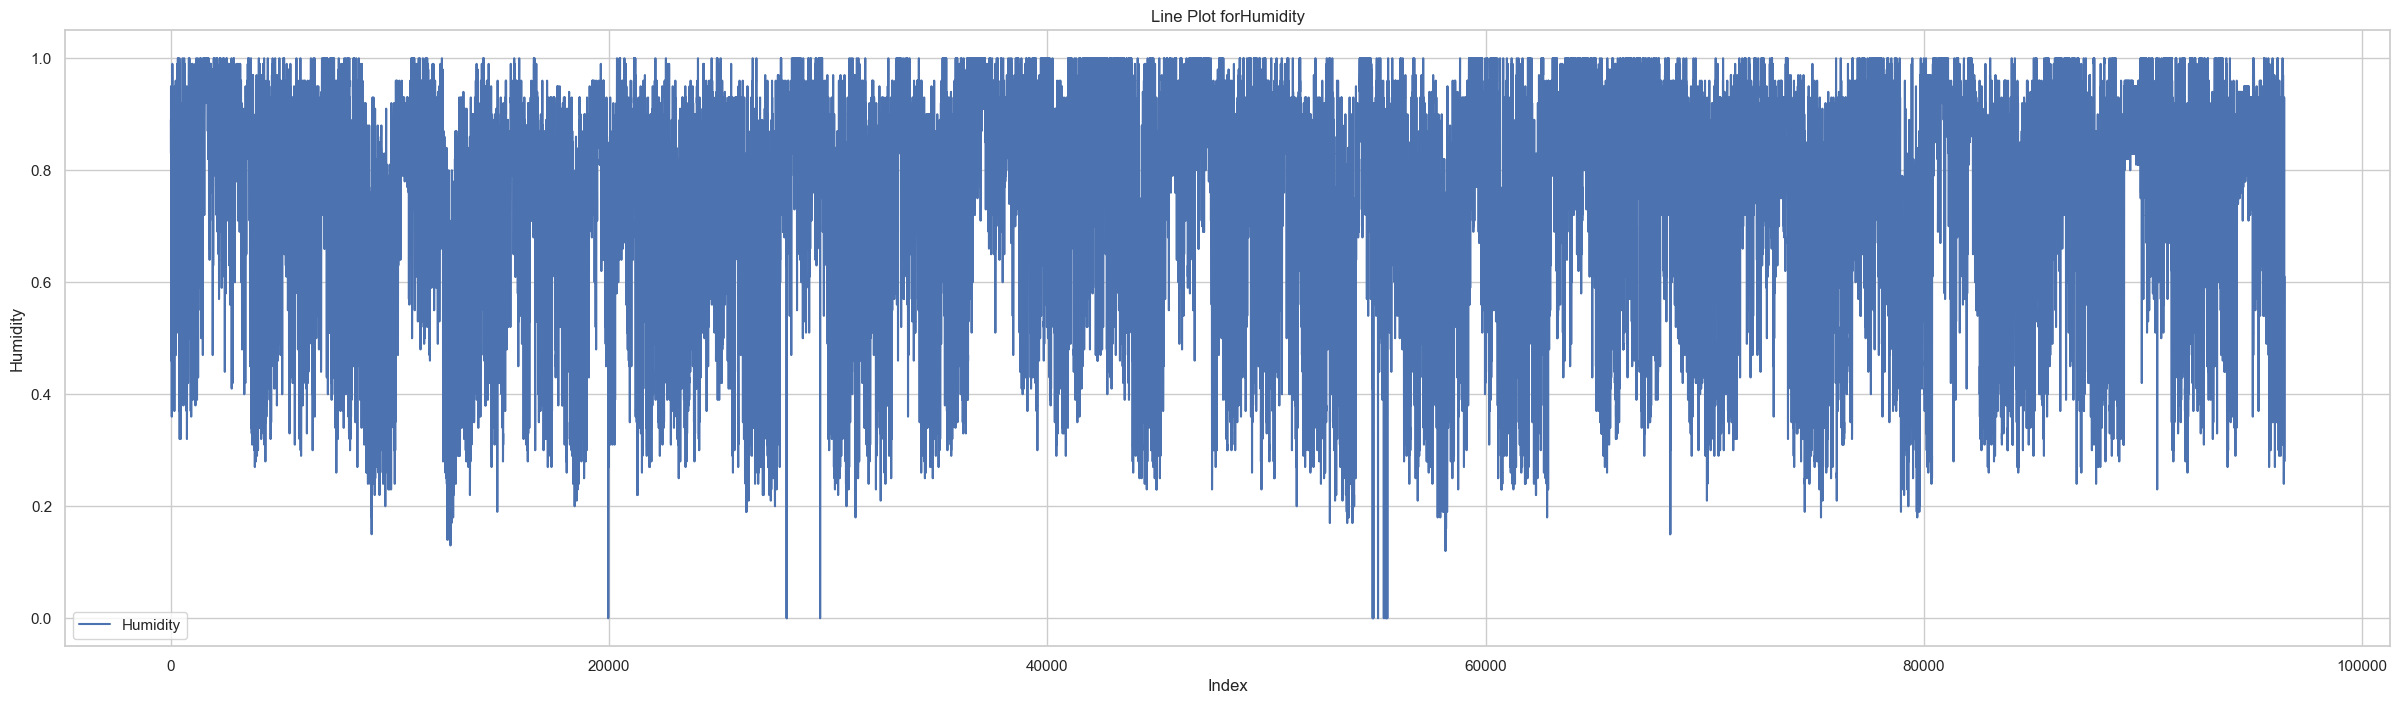

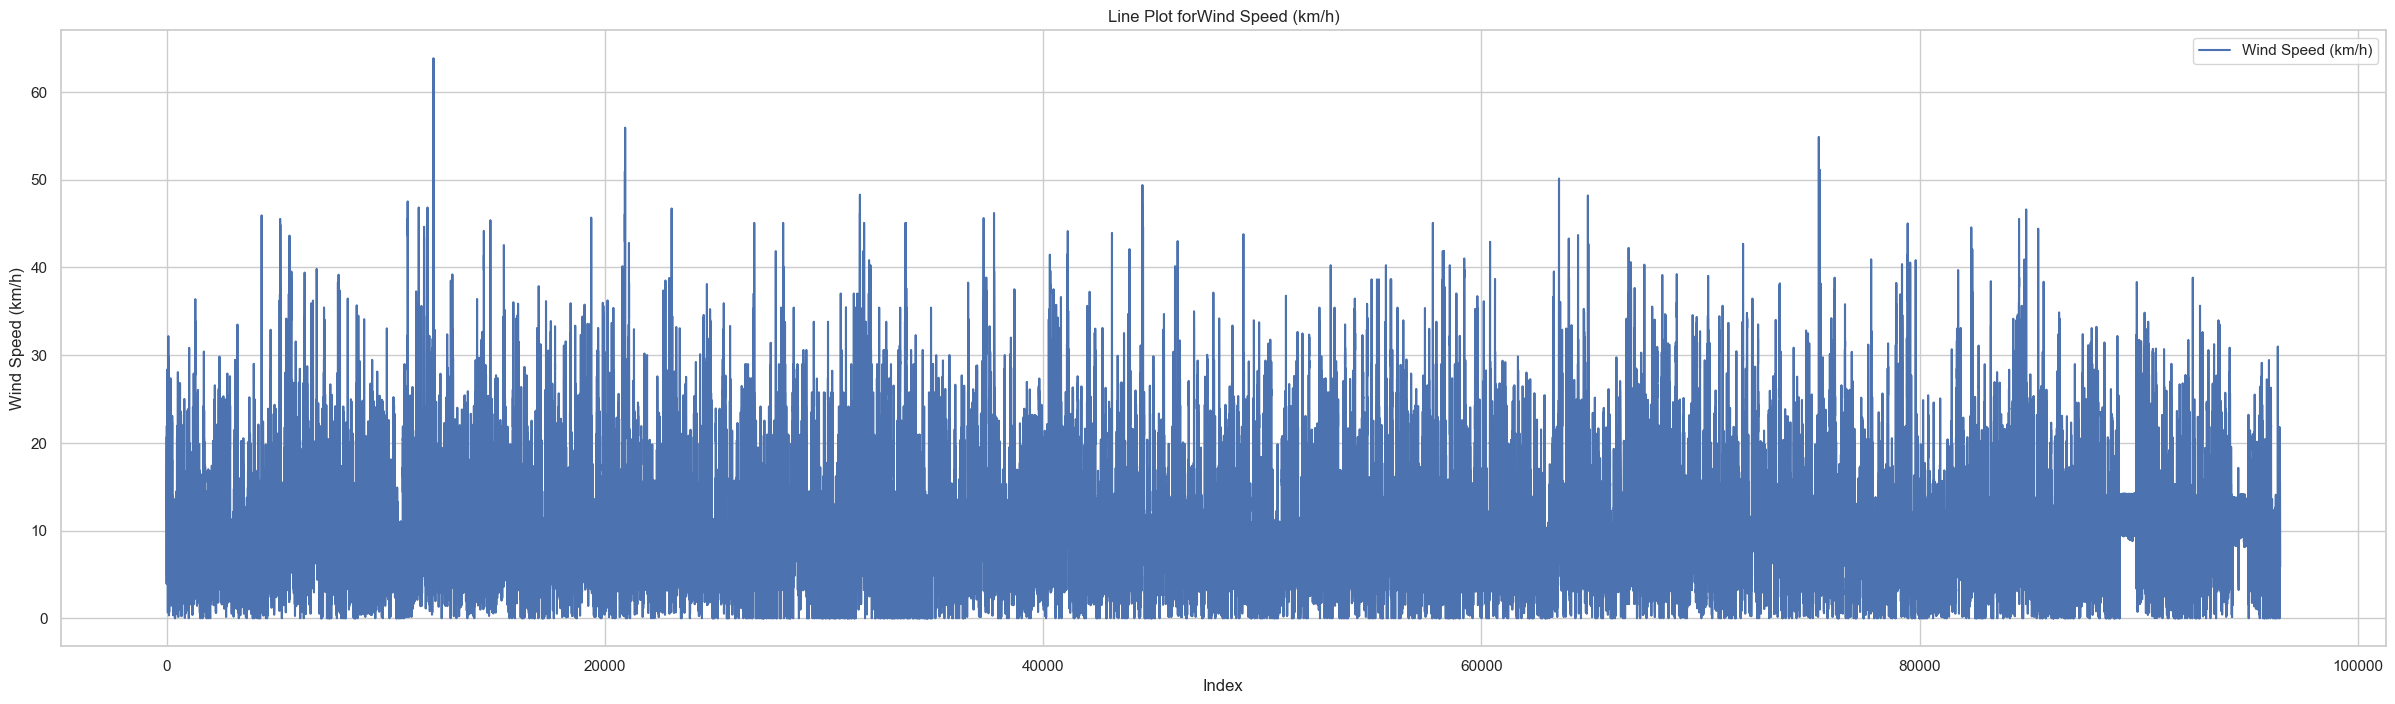

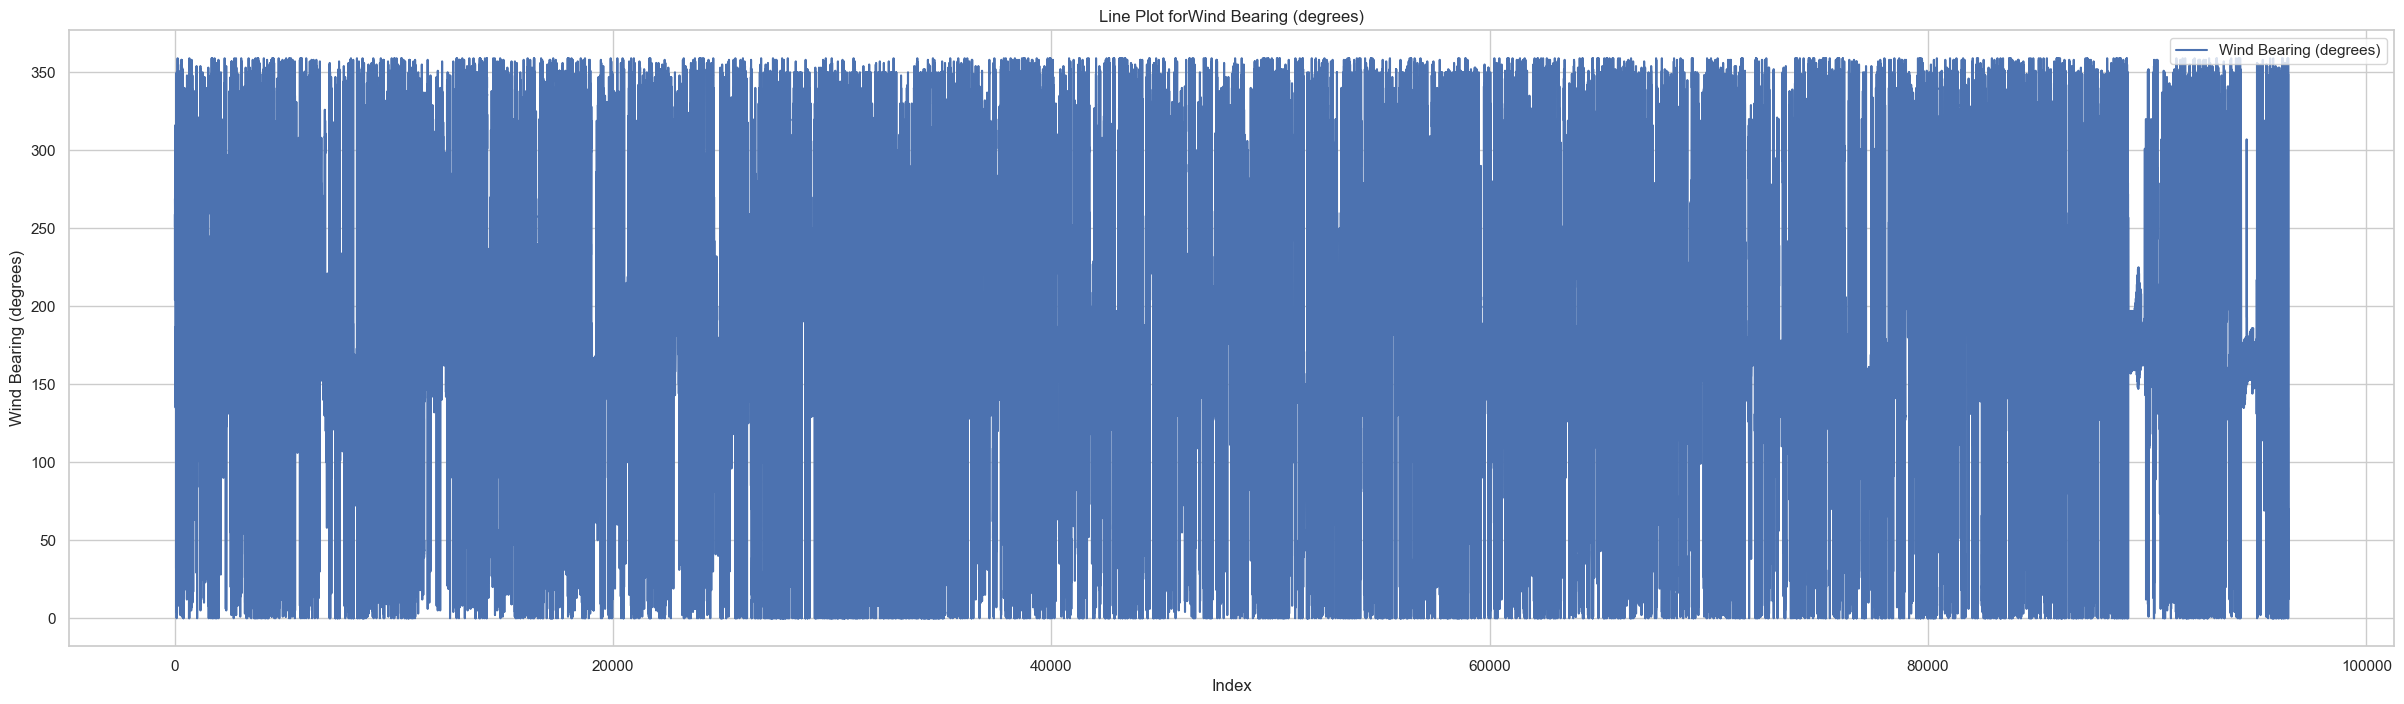

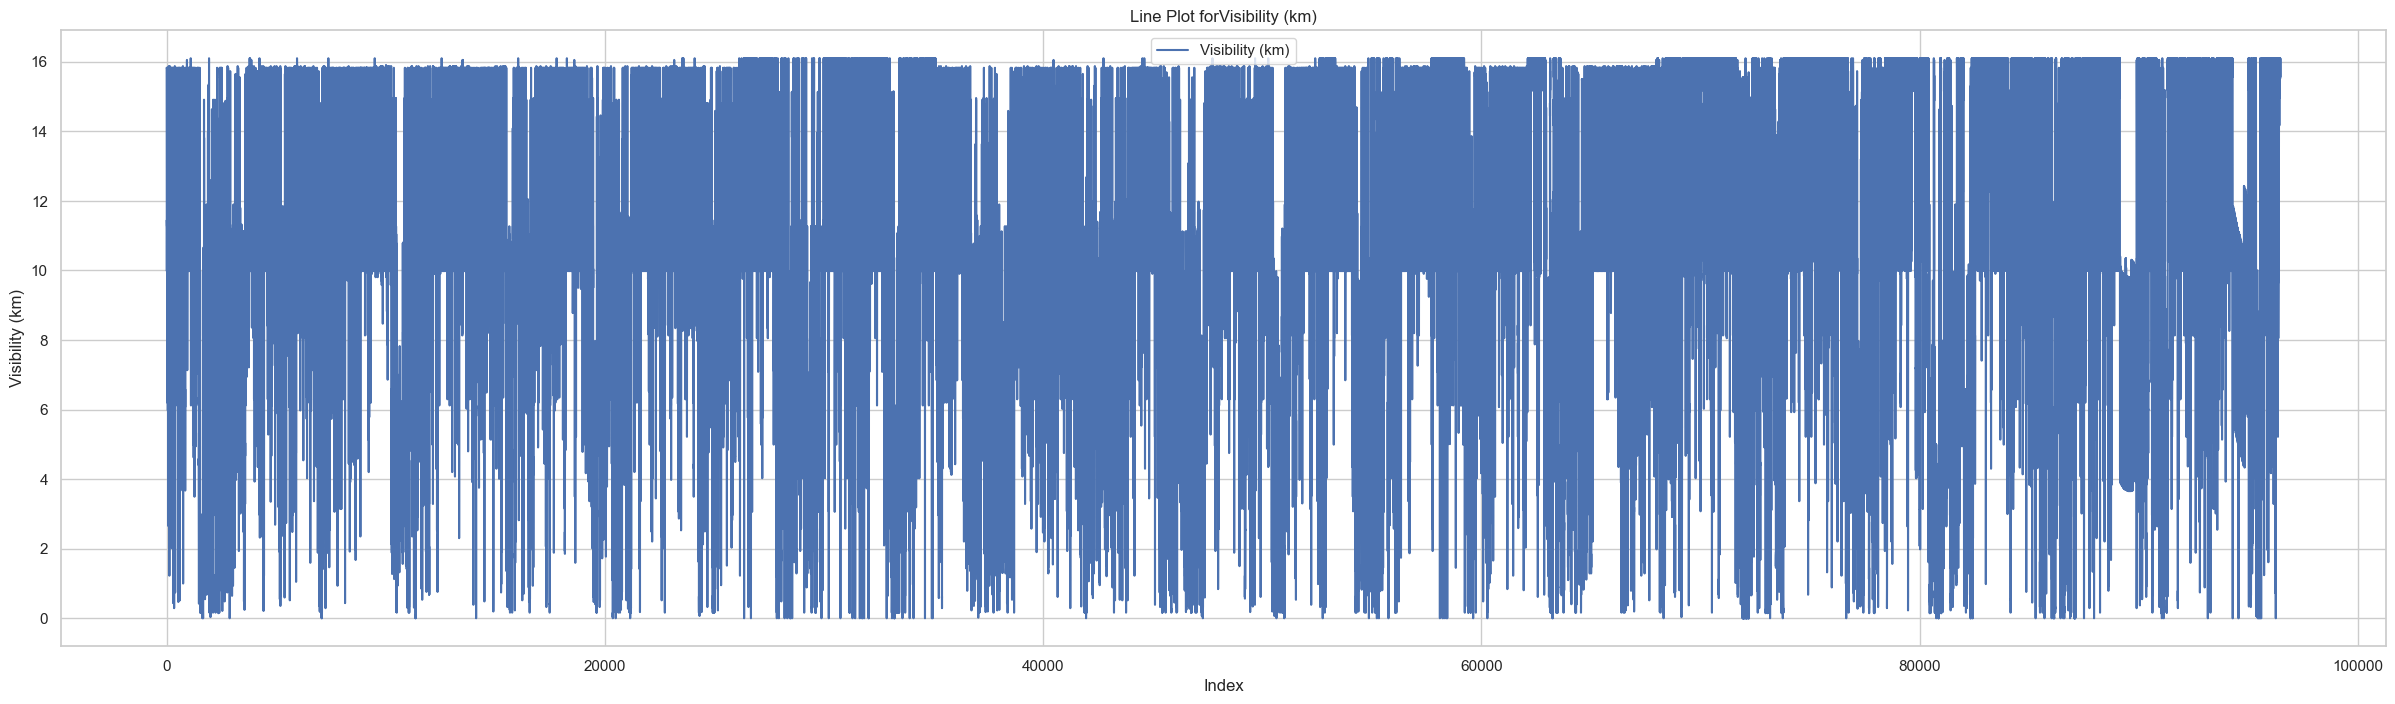

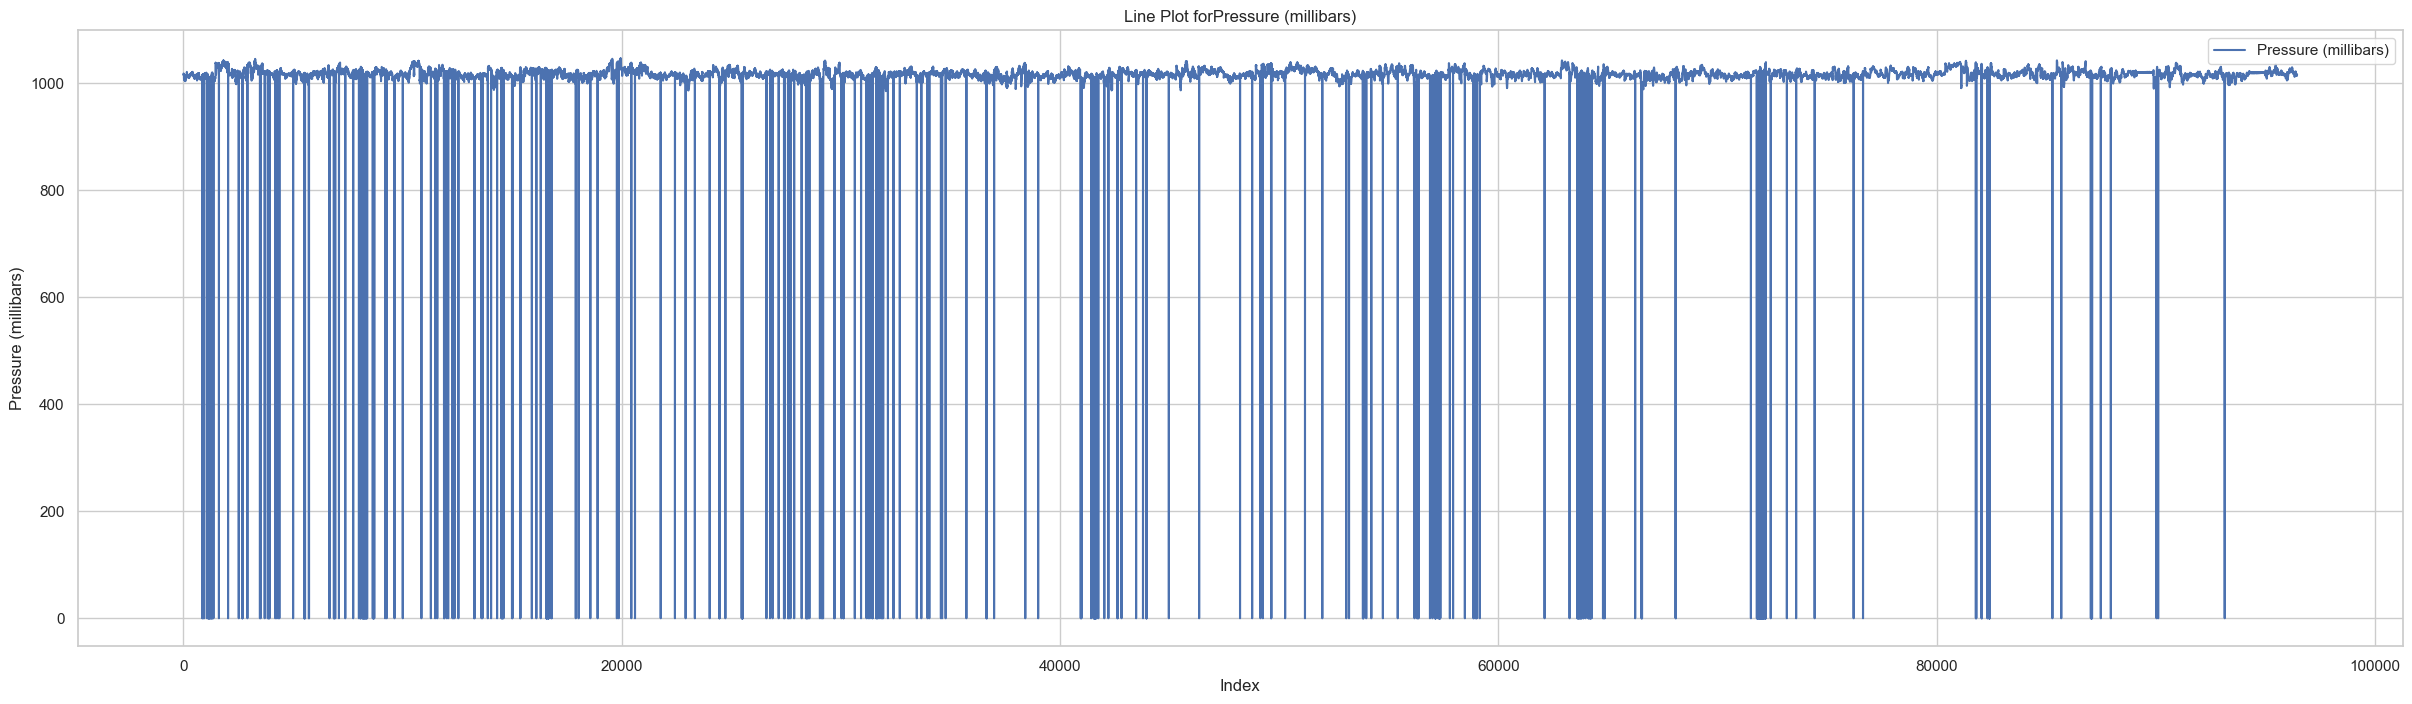

In [3]:
#data visualization

#load dataset
dv = pd.read_csv('weatherHistory.csv')


sns.set(style='whitegrid')


for column in dv.columns:
    plt.figure(figsize=(30, 8))
    
    if pd.api.types.is_numeric_dtype(dv[column]):
        plt.plot(dv[column], label=column, marker=None)  
        plt.title('Line Plot for'+ column )
        plt.xlabel('Index')
        plt.ylabel(column)
        plt.legend()
    
    plt.show()



In [4]:

# process data
df = pd.read_csv('weatherHistory.csv', index_col = 0)
scaler = StandardScaler()
scaler_model = StandardScaler()
data = scaler_model.fit_transform(np.array(df))
scaler.fit_transform(np.array(df['Temperature (C)']).reshape(-1, 1))

# get training data
def split_data(data, timestep, input_dim):
    dataX = []  
    dataY = []  


    for index in range(len(data) - timestep):
        dataX.append(data[index: index + timestep])
        dataY.append(data[index + timestep][1])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # get the size of training data
    train_size = int(np.round(0.8 * dataX.shape[0]))

    # split taining data and test data
    x_train = dataX[: train_size, :].reshape(-1, timestep, input_dim)
    y_train = dataY[: train_size]

    x_test = dataX[train_size:, :].reshape(-1, timestep, input_dim)
    y_test = dataY[train_size:]

    return [x_train, y_train, x_test, y_test]


In [5]:

x_train, y_train, x_test, y_test = split_data(data, timestep, input_dim)

In [6]:
# change to tensor type
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

In [7]:

train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)


In [8]:
# Load data into iterators
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size,
                                           True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size,
                                          False)



In [9]:
# define GRU
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim  
        self.num_layers = num_layers
        #create a GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, h_n = self.gru(x)
        batch_size, timestep, hidden_dim = output.shape  

        
        # change output to batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_dim)
        output = self.fc(output)  
        output = output.reshape(timestep, batch_size, -1)
        #return last timestamp
        return output[-1]
    
    
# define LSTM network
model = GRU(input_dim, hidden_dim, num_layers, output_dim)
# Define the loss function
loss_function = nn.MSELoss()  
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [10]:
# Traning
for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # Progress bar
    for data in train_bar:
        x_train, y_train = data 
        optimizer.zero_grad()
        #forward propagation
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        #backward propagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # Ealuation 
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test.reshape(-1, 1))
     # save the best loss
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), save_path)

print('Finished Training')

100%|█████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:01<00:00, 919.48it/s]

Finished Training


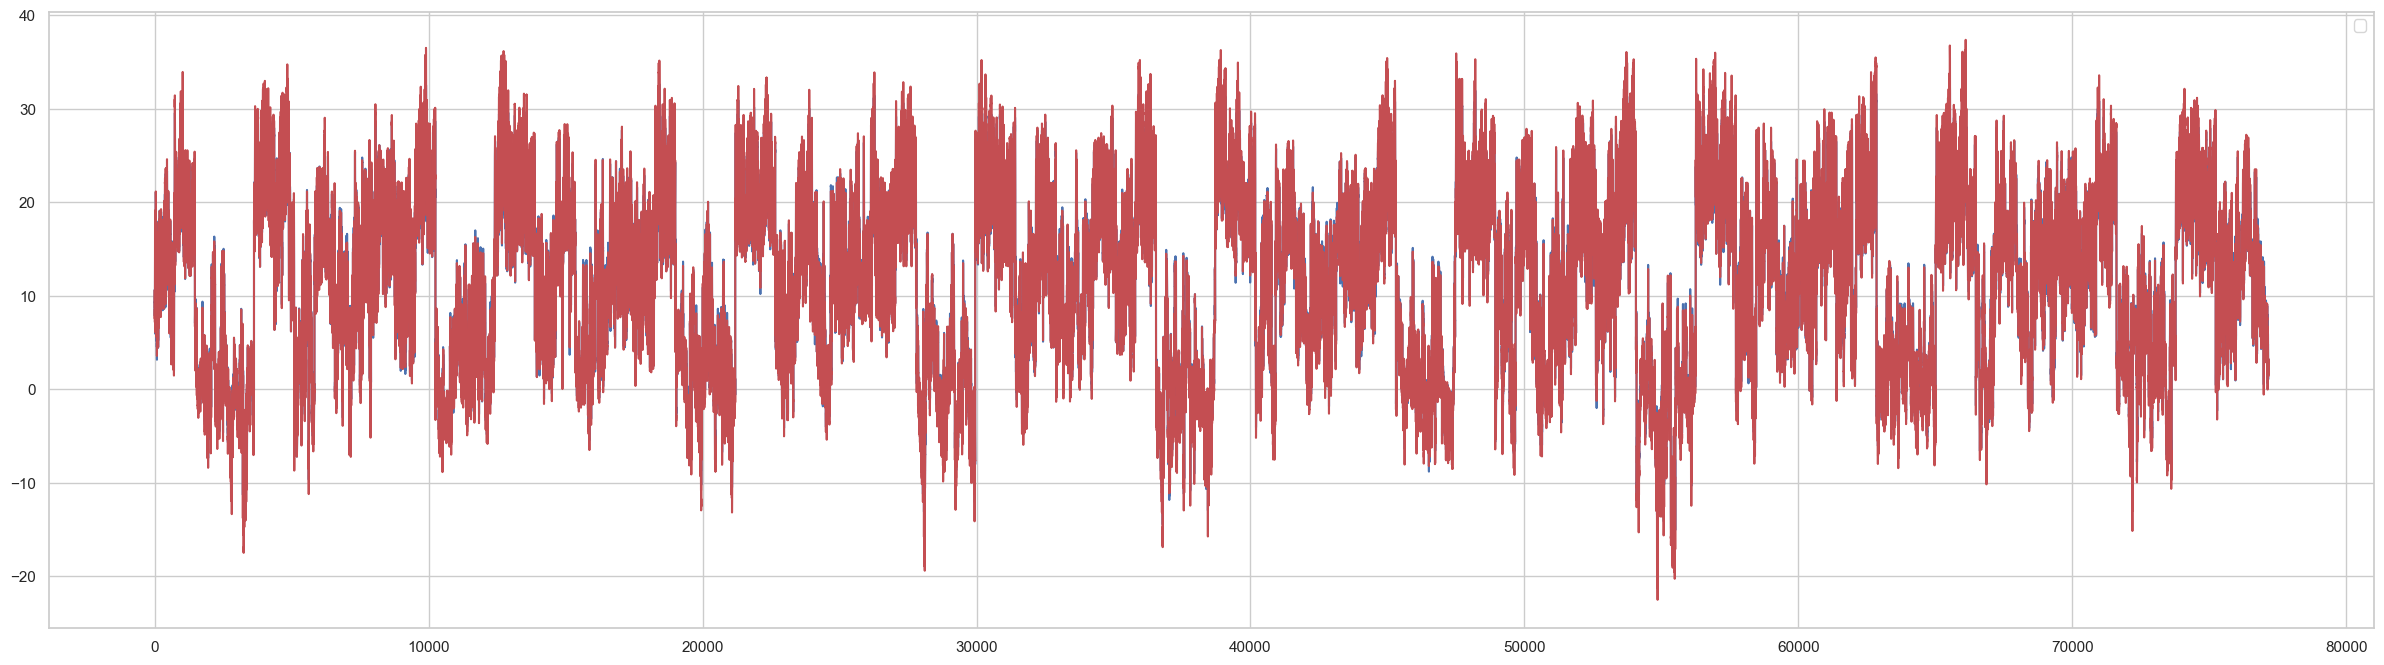

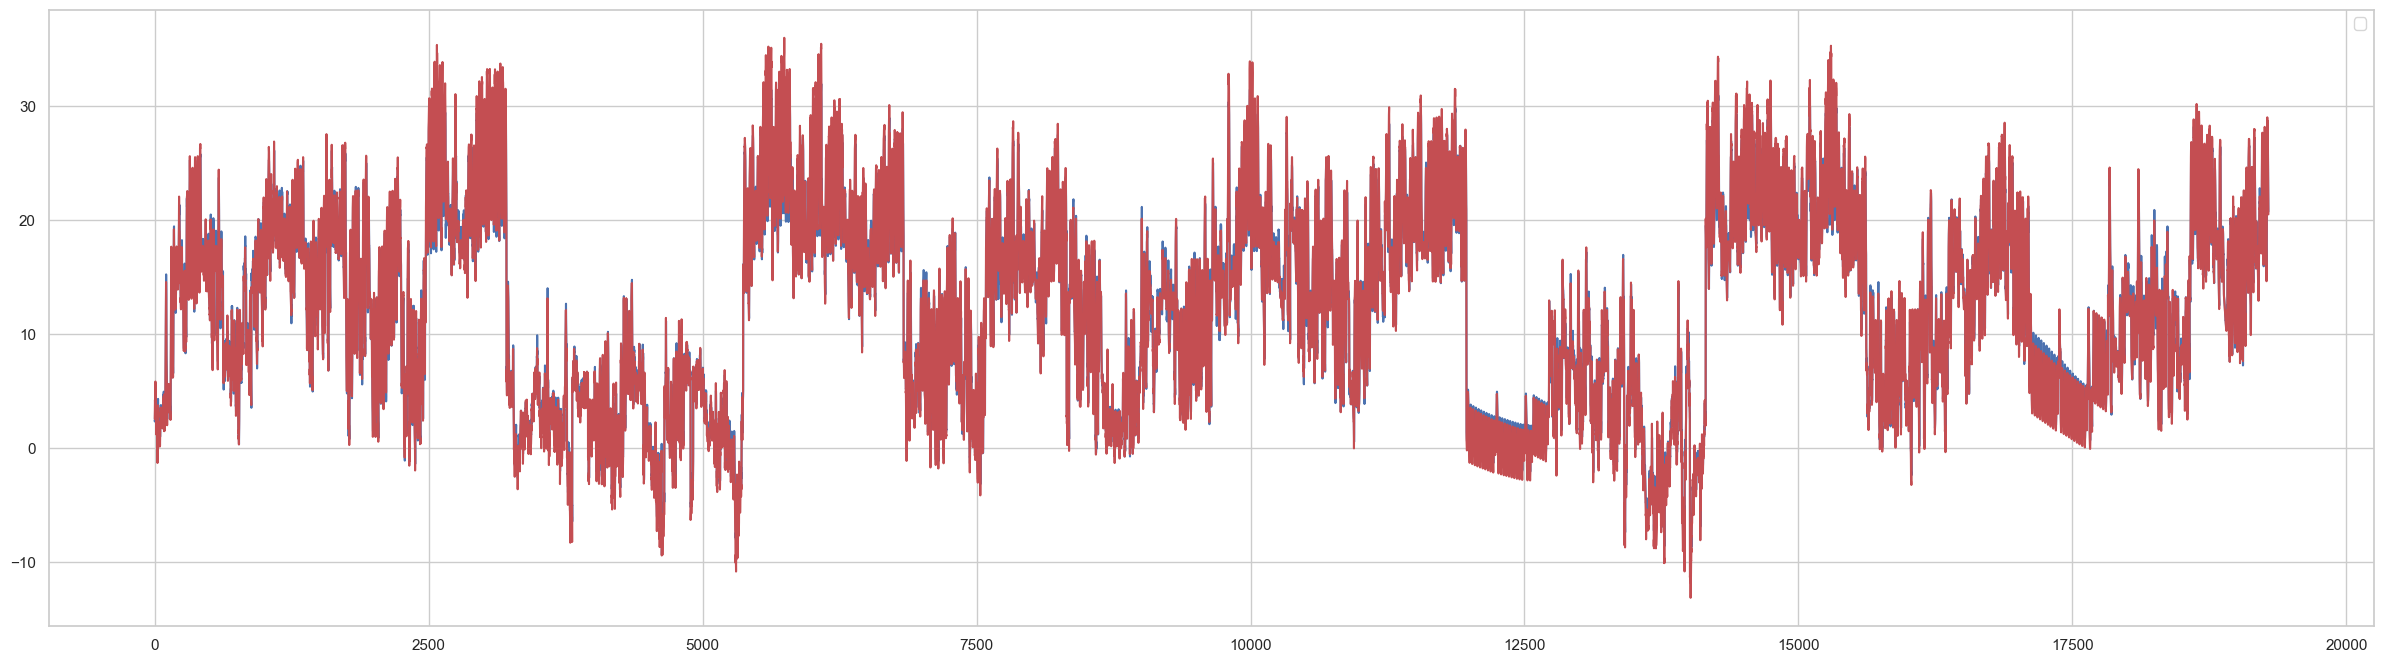

In [11]:
# Plotting
plt.figure(figsize=(30, 8))
plt.plot(scaler.inverse_transform((model(x_train_tensor).detach().numpy()).reshape(-1, 1)), "b")
plt.plot(scaler.inverse_transform(y_train_tensor.detach().numpy().reshape(-1, 1)), "r")
plt.legend()
plt.show()

y_test_pred = model(x_test_tensor)
plt.figure(figsize=(30, 8))
plt.plot(scaler.inverse_transform(y_test_pred.detach().numpy()), "b")
plt.plot(scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1)), "r")
plt.legend()
plt.show()

In [12]:

y_test_pred = model(x_test_tensor)

y_test_pred_np = scaler.inverse_transform(y_test_pred.detach().numpy().reshape(-1, 1))
y_test_true_np = scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1))

# caculate rmse
rmse = np.sqrt(mean_squared_error(y_test_true_np, y_test_pred_np))

# caculate MAE
mae = mean_absolute_error(y_test_true_np, y_test_pred_np)

# caculate R square
r2 = r2_score(y_test_true_np, y_test_pred_np)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.2f}")


RMSE: 1.47
MAE: 1.06
R-squared: 0.97
